In [7]:
import pandas as pd
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn import preprocessing, model_selection, base, linear_model
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

import datetime as dt

np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline 
os.getcwd()

'/Users/chadleonard/Springboard/work/springboard/capstone/projects/capstone1_Sberbank'

In [2]:
def fix_num_cols(dframe, skiplist):
    for col in dframe.columns.values:
        if col not in skiplist:
            if not isinstance(dframe[col][0],(str)):
                try:
                    dframe[col].fillna(dframe[col].mean(), inplace=True)
                except:
                    print('error: ' + col)
    return dframe

def get_cor(dframe, skiplist):
    flist = []
    for col in dframe.columns.values:
        if col not in skiplist:
            if not isinstance(dframe[col][0],(str)):
                try:
                    cor = np.corrcoef(dframe['price_cat'], dframe[col])
                    #if np.abs(cor[1][0]) >= .2:
                    if np.abs(cor[1][0]) >= .001:
                        flist.append(((np.abs(cor[1][0]),cor[1][0]),col))
                except:
                    print('error: ' + col)            

    return sorted(flist,reverse=True)

In [3]:
if __name__ == "__main__":
    print (dt.datetime.now())
    dir_path = os.getcwd() + '/../../../data/all/'
    print (dir_path)
    df = pd.read_csv(dir_path + 'train.csv')
    df_macro = pd.read_csv(dir_path + 'macro.csv')

    df_macro['old_education_build_share_ind'] = df_macro['old_education_build_share'].astype('category').cat.codes
    df_macro['modern_education_share_ind'] = df_macro['modern_education_share'].astype('category').cat.codes

    df_macro = df_macro.drop(['modern_education_share','old_education_build_share'], axis=1)

    df['price_cat'] = pd.Series([7.5 if cat > 5e6 and cat < 1e7 else len(str(cat)) \
                                 for cat in df['price_doc'] ]).astype('category').cat.codes
    
    df.loc[df.price_cat == 4, 'price_cat'] = 3
    df_eda = pd.merge(df, df_macro, how='inner', on='timestamp', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

    print(len(df_eda.columns.values))
    
    

2018-10-30 15:32:00.057285
/Users/chadleonard/Springboard/work/springboard/capstone/projects/capstone1_Sberbank/../../../data/all/
392


In [41]:
skip = ['id','timestamp', 'price_cat', 'price_doc']
df_train = fix_num_cols(df_eda,skip)

xfinal = [x[1] for x in get_cor(df_train,skip)]
print(len(xfinal))


scaler = preprocessing.StandardScaler(copy=True)
print(scaler.fit(df_train[xfinal]))
#print(scaler.mean_)
print(scaler.transform(df_train[xfinal]).shape)

df_train = pd.DataFrame(scaler.transform(df_train[xfinal]), columns=xfinal)
df_train['price_cat'] = df_eda['price_cat']
#df_train['sub_area'] = df_eda['sub_area'].astype('category').cat.codes

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train[xfinal], \
                                                                df_train['price_cat'], test_size=0.3)

371
StandardScaler(copy=True, with_mean=True, with_std=True)
(30471, 371)


In [9]:
print (dt.datetime.now())
clf = RandomForestClassifier(n_estimators=500, max_depth=10,random_state=0, n_jobs=2)
print(clf.fit(X_train, y_train))
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))
print (dt.datetime.now())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
0.8250738431243846
0.7887770728505797
2018-10-30 08:17:41.046769


In [4]:
# Train Test Split
skip = ['id','timestamp', 'price_cat', 'price_doc']
df_train = fix_num_cols(df_eda,skip)

xfinal = [x[1] for x in get_cor(df_train,skip)]
print(len(xfinal))

X_train, X_test, y_train, y_test = model_selection.train_test_split(df_train[xfinal], \
                                                                df_train['price_cat'], test_size=0.3)
X_train.shape

370


(21329, 370)

In [10]:
# Random Forest Classifier with PCA
print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', RandomForestClassifier(random_state=0, n_jobs=2)) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [500] , "clf__max_depth": [10], "pca__n_components": [50, 100]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-10-30 15:42:17.823359
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=50 ..
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=50 ..
[CV]  clf__max_depth=10, clf__n_estimators=500, pca__n_components=50, score=0.7140178152836381, total=  24.2s
[CV]  clf__max_depth=10, clf__n_estimators=500, pca__n_components=50, score=0.7189404594467885, total=  24.3s
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=50 ..
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=50 ..
[CV]  clf__max_depth=10, clf__n_estimators=500, pca__n_components=50, score=0.7163619315518049, total=  26.0s
[CV]  clf__max_depth=10, clf__n_estimators=500, pca__n_components=50, score=0.7090951711204876, total=  26.0s
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=50 ..
[CV] clf__max_depth=10, clf__n_estimators=500, pca__n_components=100 .
[CV]  clf__max_depth=10, clf__n_estimators=500,

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  2.8min finished


[{'clf__max_depth': 10, 'clf__n_estimators': 500, 'pca__n_components': 50}, {'clf__max_depth': 10, 'clf__n_estimators': 500, 'pca__n_components': 100}]
[0.77670984 0.77510403]
[0.7140647  0.70337553]
2018-10-30 15:45:37.636497


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [111]:
# Random Forest Classifier
print (dt.datetime.now())
pipe = Pipeline([
   ('randf', RandomForestClassifier(random_state=0, n_jobs=2)) 
    ])


cv = model_selection.ShuffleSplit(n_splits=20, test_size=0.2)
param_grid = { "randf__n_estimators": [500] , "randf__max_depth": [5,10]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy')

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv_results['params'])
print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())

2018-10-29 17:36:39.207238
[{'randf__max_depth': 5, 'randf__n_estimators': 500}, {'randf__max_depth': 10, 'randf__n_estimators': 500}]
[0.74373498 0.81741487]
[0.73793952 0.78482185]
2018-10-29 17:43:35.558933


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [29]:
# Gradient Boosting Classifier with PCA
from sklearn.ensemble import GradientBoostingClassifier

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', GradientBoostingClassifier())
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [500] , "pca__n_components": [50, 100]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 16:59:10.770984
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__n_estimators=500, pca__n_components=50 .....................
[CV] clf__n_estimators=500, pca__n_components=50 .....................
[CV]  clf__n_estimators=500, pca__n_components=50, score=0.7644163150492265, total= 3.6min
[CV]  clf__n_estimators=500, pca__n_components=50, score=0.7311298640412565, total= 3.6min
[CV] clf__n_estimators=500, pca__n_components=50 .....................
[CV] clf__n_estimators=500, pca__n_components=50 .....................
[CV]  clf__n_estimators=500, pca__n_components=50, score=0.7243319268635724, total= 3.5min
[CV] clf__n_estimators=500, pca__n_components=50 .....................
[CV]  clf__n_estimators=500, pca__n_components=50, score=0.7449601500234412, total= 3.5min
[CV] clf__n_estimators=500, pca__n_components=100 ....................
[CV]  clf__n_estimators=500, pca__n_components=50, score=0.736755743084857, total= 3.6min
[CV] clf__n_estimators=500, pca__

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 29.3min finished


{'clf__n_estimators': 500, 'pca__n_components': 100}
0.7520393811533052
[0.84006329 0.87588349]
[0.7403188  0.75203938]
2018-10-30 17:37:52.823814


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [66]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', GradientBoostingClassifier()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__n_estimators": [100,500] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 11:56:38.423094
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__n_estimators=100 ...........................................
[CV] clf__n_estimators=100 ...........................................
[CV] ............................ clf__n_estimators=100, total= 1.9min
[CV] clf__n_estimators=100 ...........................................
[CV] ............................ clf__n_estimators=100, total= 1.9min
[CV] clf__n_estimators=100 ...........................................
[CV] ............................ clf__n_estimators=100, total= 1.9min
[CV] ............................ clf__n_estimators=100, total= 1.9min
[CV] clf__n_estimators=100 ...........................................
[CV] clf__n_estimators=500 ...........................................
[CV] ............................ clf__n_estimators=100, total= 1.9min
[CV] clf__n_estimators=500 ...........................................
[CV] ............................ clf__n_estimators=500, tota

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 29.7min finished


{'clf__n_estimators': 500}
0.8034224097515237
[0.82452089 0.89333646]
[0.79962494 0.80342241]
2018-10-30 12:37:03.266426


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [65]:
# svm SVC Classifier
from sklearn.svm import SVC

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', SVC()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__kernel": ['rbf', 'sigmoid'] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 11:31:15.474800
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__kernel=rbf .................................................
[CV] clf__kernel=rbf .................................................
[CV] .................................. clf__kernel=rbf, total= 2.5min
[CV] clf__kernel=rbf .................................................
[CV] .................................. clf__kernel=rbf, total= 2.5min
[CV] clf__kernel=rbf .................................................
[CV] .................................. clf__kernel=rbf, total= 2.4min
[CV] clf__kernel=rbf .................................................
[CV] .................................. clf__kernel=rbf, total= 2.4min
[CV] clf__kernel=sigmoid .............................................
[CV] .............................. clf__kernel=sigmoid, total= 2.2min
[CV] clf__kernel=sigmoid .............................................
[CV] .................................. clf__kernel=rbf, tota

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 18.7min finished


{'clf__kernel': 'rbf'}
0.7557430848570089
[0.77883139 0.50494051]
[0.75574308 0.50070323]
2018-10-30 11:53:00.379640


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [59]:
# Ridge Classifier
from sklearn.linear_model import RidgeClassifierCV

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', RidgeClassifierCV()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__normalize": [True, False] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 11:22:10.894632
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__normalize=True .............................................
[CV] clf__normalize=True .............................................
[CV] .............................. clf__normalize=True, total=   2.2s
[CV] .............................. clf__normalize=True, total=   2.5s
[CV] clf__normalize=True .............................................
[CV] clf__normalize=True .............................................
[CV] .............................. clf__normalize=True, total=   1.5s
[CV] clf__normalize=True .............................................
[CV] .............................. clf__normalize=True, total=   1.6s
[CV] clf__normalize=False ............................................
[CV] .............................. clf__normalize=True, total=   1.4s
[CV] clf__normalize=False ............................................
[CV] ............................. clf__normalize=False, tota

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    9.7s finished


{'clf__normalize': False}
0.6767463666197844
[0.68102913 0.68720624]
[0.67487107 0.67674637]
2018-10-30 11:22:22.103023


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [28]:
# Ridge Classifier with PCA
from sklearn.linear_model import RidgeClassifier

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', RidgeClassifier())
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__solver": ['sag', 'lsqr'], "pca__n_components": [50, 100] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 16:49:48.509404
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] clf__solver=sag, pca__n_components=50 ...........................
[CV] clf__solver=sag, pca__n_components=50 ...........................
[CV]  clf__solver=sag, pca__n_components=50, score=0.6523675574308486, total=   2.6s
[CV]  clf__solver=sag, pca__n_components=50, score=0.6570557899671824, total=   2.7s
[CV] clf__solver=sag, pca__n_components=50 ...........................
[CV] clf__solver=sag, pca__n_components=50 ...........................
[CV]  clf__solver=sag, pca__n_components=50, score=0.650492264416315, total=   2.1s
[CV]  clf__solver=sag, pca__n_components=50, score=0.6556493202062822, total=   2.2s
[CV] clf__solver=sag, pca__n_components=50 ...........................
[CV] clf__solver=sag, pca__n_components=100 ..........................
[CV]  clf__solver=sag, pca__n_components=50, score=0.659634317862166, total=   2.2s
[CV]  clf__solver=sag, pca__n_components=100, score=0.6821378340

[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   25.4s finished


{'clf__solver': 'sag', 'pca__n_components': 100}
0.6685888420065635
[0.66009494 0.67298834 0.66028248 0.67355096]
[0.65503985 0.66858884 0.65499297 0.66826067]
2018-10-30 16:50:16.932383


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [58]:
# Ridge Classifier
from sklearn.linear_model import RidgeClassifier

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', RidgeClassifier()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__solver": ['sag', 'lsqr',] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 11:13:24.503348
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__solver=sag .................................................
[CV] clf__solver=sag .................................................
[CV] .................................. clf__solver=sag, total= 1.8min
[CV] clf__solver=sag .................................................
[CV] .................................. clf__solver=sag, total= 2.1min
[CV] clf__solver=sag .................................................
[CV] .................................. clf__solver=sag, total= 1.8min
[CV] clf__solver=sag .................................................
[CV] .................................. clf__solver=sag, total= 1.9min
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.9s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, tota

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  5.6min finished


{'clf__solver': 'lsqr'}
0.6745897796530708
[0.68585829 0.68587001]
[0.67398031 0.67458978]
2018-10-30 11:19:01.743783


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [53]:
# Radius Neighbors Classifier
from sklearn.neighbors import RadiusNeighborsClassifier

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', RadiusNeighborsClassifier(weights='distance')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__algorithm": ["kd_tree", "ball_tree"], "clf__outlier_label": [2,3] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 10:38:21.028394
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] clf__algorithm=kd_tree, clf__outlier_label=2 ....................
[CV] clf__algorithm=kd_tree, clf__outlier_label=2 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=2, total=  27.7s
[CV] clf__algorithm=kd_tree, clf__outlier_label=2 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=2, total=  31.7s
[CV] clf__algorithm=kd_tree, clf__outlier_label=2 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=2, total=  27.0s
[CV] clf__algorithm=kd_tree, clf__outlier_label=2 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=2, total=  31.6s
[CV] clf__algorithm=kd_tree, clf__outlier_label=3 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=2, total=  29.3s
[CV] clf__algorithm=kd_tree, clf__outlier_label=3 ....................
[CV] ..... clf__algorithm=kd_tree, clf__outlier_label=3, tota

[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 26.3min finished


{'clf__algorithm': 'kd_tree', 'clf__outlier_label': 2}
0.59957805907173
[1. 1. 1. 1.]
[0.59957806 0.26544773 0.59957806 0.26544773]
2018-10-30 11:04:40.110088


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [50]:
# Quadratic Discriminant Analysis Classifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', QuadraticDiscriminantAnalysis()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__store_covariance": [True,False] }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 10:32:18.245367
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__store_covariance=True ......................................
[CV] clf__store_covariance=True ......................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packa

[CV] ....................... clf__store_covariance=True, total=   1.8s
[CV] ....................... clf__store_covariance=True, total=   2.2s
[CV] clf__store_covariance=True ......................................
[CV] clf__store_covariance=True ......................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packa

[CV] ....................... clf__store_covariance=True, total=   1.5s
[CV] clf__store_covariance=True ......................................
[CV] ....................... clf__store_covariance=True, total=   1.6s
[CV] clf__store_covariance=False .....................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packa

[CV] ....................... clf__store_covariance=True, total=   1.6s
[CV] clf__store_covariance=False .....................................
[CV] ...................... clf__store_covariance=False, total=   1.6s
[CV] clf__store_covariance=False .....................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packa

[CV] ...................... clf__store_covariance=False, total=   1.5s
[CV] ...................... clf__store_covariance=False, total=   1.5s
[CV] clf__store_covariance=False .....................................
[CV] clf__store_covariance=False .....................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packa

[CV] ...................... clf__store_covariance=False, total=   1.5s
[CV] ...................... clf__store_covariance=False, total=   1.5s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   13.5s finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


{'clf__store_covariance': True}
0.4078762306610408
[0.42178984 0.42178984]
[0.40787623 0.40787623]
2018-10-30 10:32:32.871569


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [13]:
# Neural Network MLP Classifier with PCA
from sklearn.neural_network import MLPClassifier

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', MLPClassifier())
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__hidden_layer_sizes": [(25, 11, 7, 5, 3,)], "pca__n_components": [150, 200]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)


pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 15:56:03.097152
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150 
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150 
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150, score=0.7480075011720582, total=  13.5s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150 
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150, score=0.76699484294421, total=  14.1s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150 
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150, score=0.7550398499765588, total=  14.6s
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150, score=0.7573839662447257, total=  15.8s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=150 
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3), pca__n_components=200 
[CV]  clf__hidden_layer_sizes=(25, 11, 7,

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.6min finished


{'clf__hidden_layer_sizes': (25, 11, 7, 5, 3), 'pca__n_components': 150}
0.7552742616033755
[0.8861396  0.89970111]
[0.75527426 0.72395687]
2018-10-30 15:57:56.525185


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [16]:
# Neural Network MLP Classifier
from sklearn.neural_network import MLPClassifier

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('clf', MLPClassifier())
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__hidden_layer_sizes": [(25, 11, 7, 5, 3,)]}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)


pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 15:59:47.834577
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3) .......................
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3) .......................
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), score=0.7941865916549461, total=  13.2s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3) .......................
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), score=0.7796530707923113, total=  20.8s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3) .......................
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), score=0.7836380684481951, total=  20.9s
[CV] clf__hidden_layer_sizes=(25, 11, 7, 5, 3) .......................
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), score=0.7838724800750118, total=  18.9s
[CV]  clf__hidden_layer_sizes=(25, 11, 7, 5, 3), score=0.7960618846694796, total=  11.1s


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   47.8s finished


{'clf__hidden_layer_sizes': (25, 11, 7, 5, 3)}
0.7874824191279888
[0.8596847]
[0.78748242]
2018-10-30 16:00:50.153439


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [ ]:
# MLPClassifier
{'clf__hidden_layer_sizes': (25, 11, 7, 5, 3)}
0.7874355368026255
[0.857317]
[0.78743554]
2018-10-30 10:29:35.185666

In [19]:
# Logistic Regression Multi-class Classifier with PCA
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', LogisticRegression(multi_class='multinomial', n_jobs=2, solver='newton-cg')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = { "clf__fit_intercept": [True] , "pca__n_components": [50, 100] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 16:09:26.885715
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV] clf__fit_intercept=True, pca__n_components=50 ...................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7365213314580403, total=   2.6s
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7090951711204876, total=   2.9s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV] clf__fit_intercept=True, pca__n_components=50 ...................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7198781059540553, total=   2.2s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7086263478668542, total=   2.5s
[CV] clf__fit_intercept=True, pca__n_components=100 ..................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7320675105485233, total=   2.3s
[CV] clf__fit_intercept=True, pca__n_components=100 ..................
[CV]  clf__fit_intercept=True, pca__n_components=100, score=0.7510548523206751, total=   3.4s
[CV] clf__fit_intercept=True, pca__n_components=100 ..................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  clf__fit_intercept=True, pca__n_components=100, score=0.7592592592592593, total=   3.9s
[CV] clf__fit_intercept=True, pca__n_components=100 ..................
[CV]  clf__fit_intercept=True, pca__n_components=100, score=0.7550398499765588, total=   3.8s
[CV] clf__fit_intercept=True, pca__n_components=100 ..................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV]  clf__fit_intercept=True, pca__n_components=100, score=0.7430848570089077, total=   3.6s
[CV]  clf__fit_intercept=True, pca__n_components=100, score=0.759493670886076, total=   3.3s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   18.5s finished


{'clf__fit_intercept': True, 'pca__n_components': 100}
0.7535864978902953
[0.72535896 0.76292563]
[0.72123769 0.7535865 ]
2018-10-30 16:09:52.106909


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [38]:
# Logistic Regression Multi-class Classifier
from sklearn.linear_model import LogisticRegression

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', LogisticRegression(multi_class='multinomial', n_jobs=2, solver='newton-cg')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = { "clf__fit_intercept": [True,False]  }
pipe_est_cv = model_selection.GridSearchCV(pipe,param_grid=param_grid,cv=cv,scoring='accuracy',verbose=2,n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 09:45:25.105113
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] clf__fit_intercept=True .........................................
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   5.4s
[CV] .......................... clf__fit_intercept=True, total=   5.5s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   5.0s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   5.1s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   4.5s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   4.8s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   4.8s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   4.8s
[CV] clf__fit_intercept=True .........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   4.6s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] .......................... clf__fit_intercept=True, total=   5.5s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   5.3s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   4.9s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   5.1s
[CV] ......................... clf__fit_intercept=False, total=   5.0s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   4.9s
[CV] clf__fit_intercept=False ........................................
[CV] ......................... clf__fit_intercept=False, total=   5.1s


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   5.3s
[CV] ......................... clf__fit_intercept=False, total=   5.3s
[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] clf__fit_intercept=False ........................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] ......................... clf__fit_intercept=False, total=   5.0s
[CV] ......................... clf__fit_intercept=False, total=   5.1s


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   51.8s finished


{'clf__fit_intercept': True}
0.7477496483825598
[0.75568188 0.60774776]
[0.74774965 0.60030474]
2018-10-30 09:46:29.514643


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [ ]:
# LogisticRegression
{'clf__solver': 'newton-cg'}
0.7501640881387717

In [20]:
# Linear SVC Classifier with PCA
from sklearn.svm import LinearSVC

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', LinearSVC(multi_class='crammer_singer')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = { "clf__fit_intercept": [True] , "pca__n_components": [50, 100] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 16:12:56.217639
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7046413502109705, total=  17.1s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7290201593999063, total=  20.8s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.710267229254571, total=  14.9s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.7189404594467885, total=  24.3s
[CV] clf__fit_intercept=True, pca__n_components=50 ...................
[CV]  clf__fit_intercept=True, pca__n_components=50, score=0.6983122362869199, total=  15.9s
[CV] clf__fit_intercep

[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  6.6min finished


{'clf__fit_intercept': True, 'pca__n_components': 100}
0.7652133145804032
[0.71993202 0.77138252]
[0.71394749 0.76521331]
2018-10-30 16:20:36.238259


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [33]:
# Linear SVC Classifier
from sklearn.svm import LinearSVC

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', LinearSVC(multi_class='crammer_singer')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = { "clf__fit_intercept": [True,False] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 09:11:15.343495
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  35.8s
[CV] clf__fit_intercept=True .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.9s remaining:    0.0s


[CV] .......................... clf__fit_intercept=True, total=  36.6s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  35.7s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  34.7s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  39.4s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  32.4s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  36.6s
[CV] clf__fit_intercept=True .........................................
[CV] .......................... clf__fit_intercept=True, total=  36.6s
[CV] clf__fit_intercept=True .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 12.4min finished


{'clf__fit_intercept': True}
0.7603141115799343
[0.76399226 0.61877747]
[0.76031411 0.61368964]
2018-10-30 09:24:25.177575


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [26]:
# Linear Discrimant Analysis Classifier with PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', LinearDiscriminantAnalysis()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=5, test_size=0.2)
param_grid = {  "clf__solver": ['svd','lsqr'] , "pca__n_components": [250] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)
pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 16:43:26.827401
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] clf__solver=svd, pca__n_components=250 ..........................
[CV] clf__solver=svd, pca__n_components=250 ..........................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[CV]  clf__solver=svd, pca__n_components=250, score=0.7055789967182372, total=   4.0s
[CV]  clf__solver=svd, pca__n_components=250, score=0.7037037037037037, total=   4.0s
[CV] clf__solver=svd, pca__n_components=250 ..........................
[CV] clf__solver=svd, pca__n_components=250 ..........................
[CV]  clf__solver=svd, pca__n_components=250, score=0.7006563525550867, total=   3.3s
[CV]  clf__solver=svd, pca__n_components=250, score=0.6938584153774027, total=   3.3s
[CV] clf__solver=svd, pca__n_components=250 ..........................
[CV] clf__solver=lsqr, pca__n_components=250 .........................
[CV]  clf__solver=svd, pca__n_components=250, score=0.6889357712142522, total=   3.0s
[CV]  clf__solver=lsqr, pca__n_components=250, score=0.7053445850914205, total=   2.9s
[CV] clf__solver=lsqr, pca__n_components=250 .........................
[CV] clf__solver=lsqr, pca__n_components=250 .........................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[CV]  clf__solver=lsqr, pca__n_components=250, score=0.7037037037037037, total=   2.8s
[CV] clf__solver=lsqr, pca__n_components=250 .........................
[CV]  clf__solver=lsqr, pca__n_components=250, score=0.7008907641819034, total=   3.1s
[CV] clf__solver=lsqr, pca__n_components=250 .........................
[CV]  clf__solver=lsqr, pca__n_components=250, score=0.6936240037505861, total=   3.0s
[CV]  clf__solver=lsqr, pca__n_components=250, score=0.6887013595874355, total=   2.9s


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   22.7s finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


{'clf__solver': 'svd', 'pca__n_components': 250}
0.6985466479137366
[0.70487019 0.70497568]
[0.69854665 0.69845288]
2018-10-30 16:43:52.355346


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [32]:
# Linear Discrimant Analysis Classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', LinearDiscriminantAnalysis()) 
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = { "clf__solver": ['svd','lsqr'] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 09:07:18.727422
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] clf__solver=svd .................................................
[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................
[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................
[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................
[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................
[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=svd .................................................


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


[CV] .................................. clf__solver=svd, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] ................................. clf__solver=lsqr, total=   0.1s
[CV] clf__solver=lsqr ................................................
[CV] .

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.0s finished


{'clf__solver': 'svd'}
0.6947022972339428
[0.69599719 0.69166618]
[0.6947023  0.69008439]
2018-10-30 09:07:20.834117


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [21]:
# K-nearest Neighbor Classifier with PCA
from sklearn.neighbors import KNeighborsClassifier 

pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', KNeighborsClassifier(n_jobs=2, weights='distance'))
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = {  "clf__n_neighbors": [15] , "clf__algorithm": ['kd_tree'], "pca__n_components": [50, 100] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV]  clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50, score=0.6739334270979841, total=   8.3s
[CV]  clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50, score=0.689873417721519, total=   8.3s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV]  clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50, score=0.6659634317862166, total=   8.2s
[CV]  clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50, score=0.6903422409751524, total=   8.4s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15, pca__n_components=50 
[CV]  clf__algorithm=kd_tree, clf__n_neighbors=15, pca__

[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  9.2min finished


{'clf__algorithm': 'kd_tree', 'clf__n_neighbors': 15, 'pca__n_components': 50}
0.6846929207688701
[0.99175995 0.99950185]
[0.68469292 0.67526957]
2018-10-30 16:36:09.567805


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [28]:
# K-nearest Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier 

print (dt.datetime.now())
pipe = Pipeline([
   ('clf', KNeighborsClassifier(n_jobs=2, weights='distance')) 
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = { "clf__n_neighbors": [15] , "clf__algorithm": ['kd_tree']}
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])
print (dt.datetime.now())


2018-10-30 08:59:19.762423
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.3s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.3s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.1s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.5s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.1s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.5s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.1s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] ...... clf__algorithm=kd_tree, clf__n_neighbors=15, total=   2.1s
[CV] clf__algorithm=kd_tree, clf__n_neighbors=15 .....................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'clf__n_neighbors': 10, 'clf__weights': 'distance'}
0.7555555555555555


In [27]:
# Guassian Naive Bayes
print (dt.datetime.now())
pipe = Pipeline([
       ('scaling', preprocessing.StandardScaler()),
       ('pca', PCA(whiten=True)),
       ('clf', GaussianNB())
    ])

cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2)
param_grid = {  "pca__n_components": [50, 100] }
pipe_est_cv = model_selection.GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring='accuracy', \
                                           verbose=3, n_jobs=2)

pipe_est_cv.fit(X_train, y_train)
pipe_est_cv_results = pipe_est_cv.cv_results_

print(pipe_est_cv.best_params_)
print(pipe_est_cv.best_score_)

print(pipe_est_cv_results['mean_train_score'])
print(pipe_est_cv_results['mean_test_score'])

print (dt.datetime.now())

2018-10-30 16:45:38.272257
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] pca__n_components=50 ............................................
[CV] pca__n_components=50 ............................................
[CV] ... pca__n_components=50, score=0.5740740740740741, total=   1.6s
[CV] ... pca__n_components=50, score=0.5773558368495078, total=   1.6s
[CV] pca__n_components=50 ............................................
[CV] pca__n_components=50 ............................................
[CV] ... pca__n_components=50, score=0.5747773089545242, total=   1.1s
[CV] ... pca__n_components=50, score=0.5782934833567746, total=   1.2s
[CV] pca__n_components=50 ............................................
[CV] pca__n_components=50 ............................................
[CV] ... pca__n_components=50, score=0.5750117205813409, total=   2.6s
[CV] ... pca__n_components=50, score=0.5855602437880919, total=   2.6s
[CV] pca__n_components=50 ..................................

[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   29.0s finished


{'pca__n_components': 50}
0.577332395686826
[0.57770615 0.54999121]
[0.5773324 0.5480075]
2018-10-30 16:46:08.514364


/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [94]:
pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]

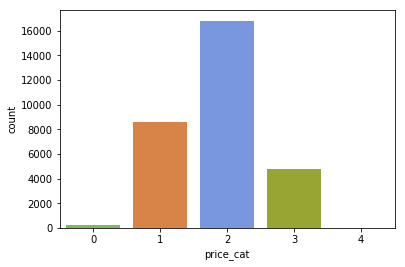

In [102]:
sns.countplot(x='price_cat', data=df, palette=pkmn_type_colors)

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


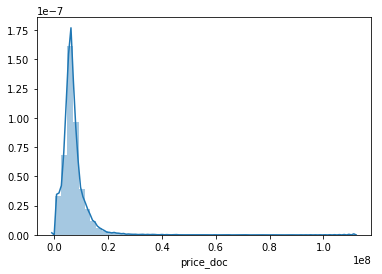

In [98]:
# Distribution Plot (a.k.a. Histogram)
sns.distplot(df.price_doc)

In [ ]:
for col in xfinal[:5]:
    print(col)
    sns.violinplot(x="price_cat", y=col, data=X_train[['price_cat',col]])

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


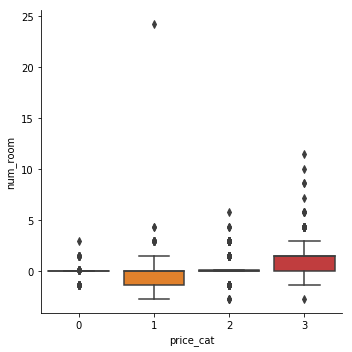

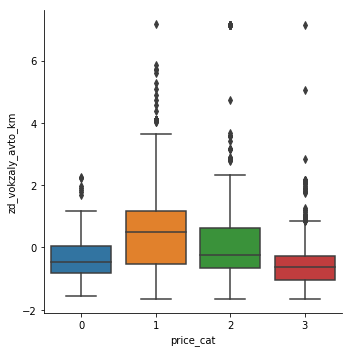

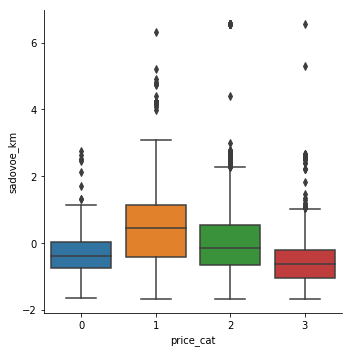

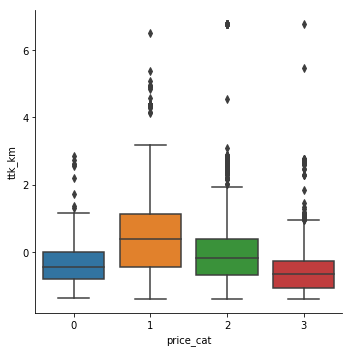

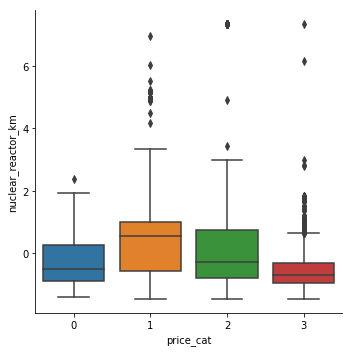

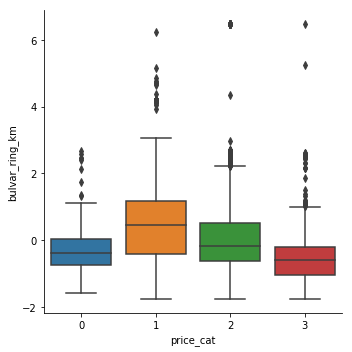

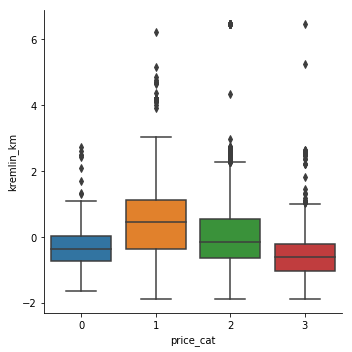

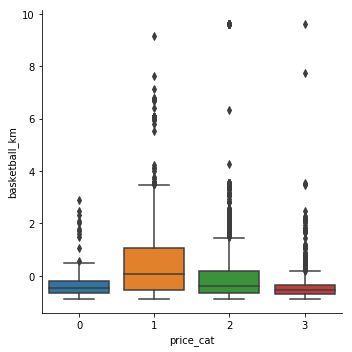

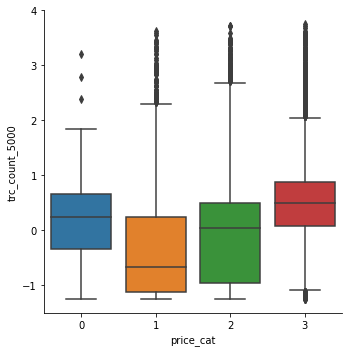

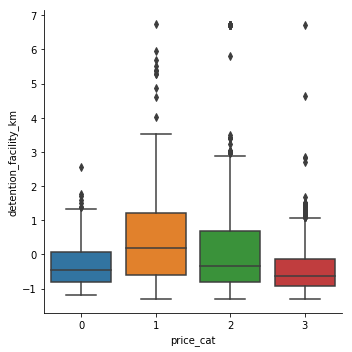

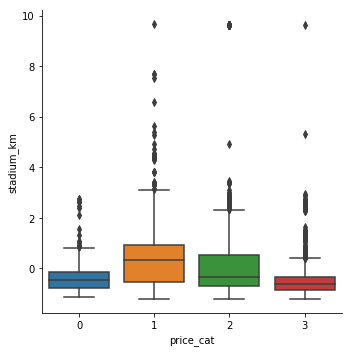

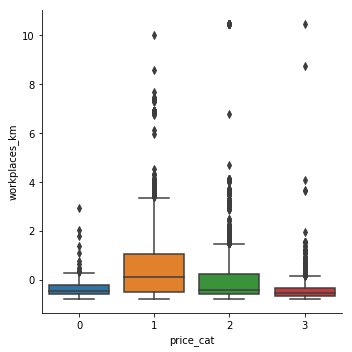

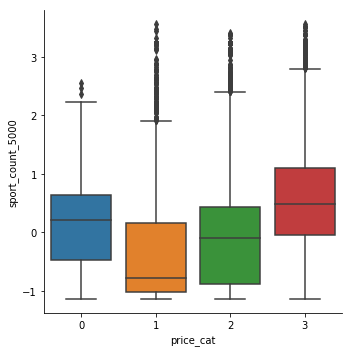

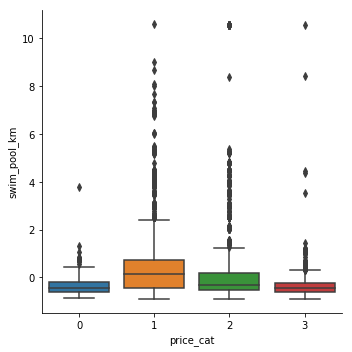

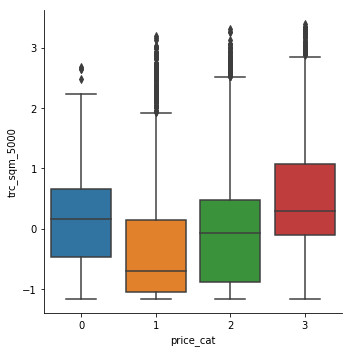

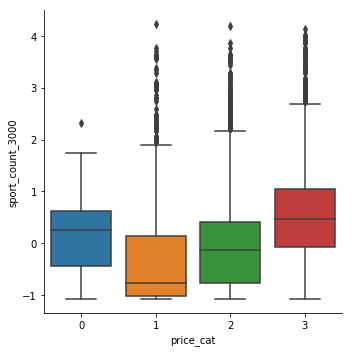

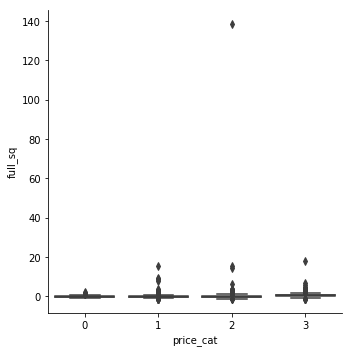

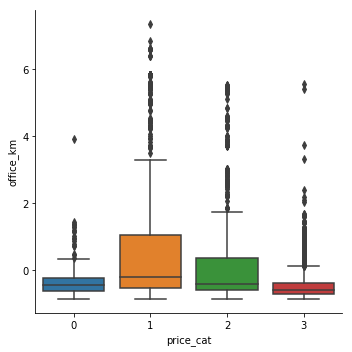

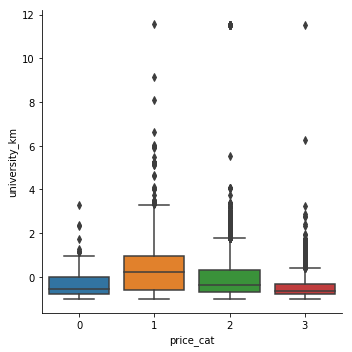

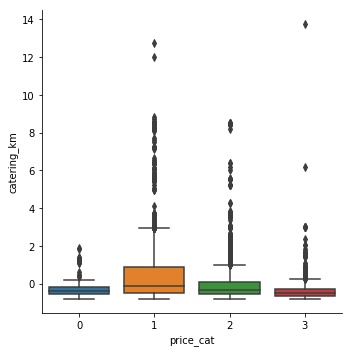

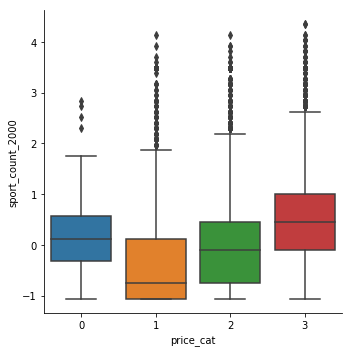

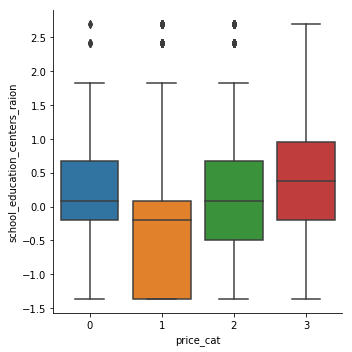

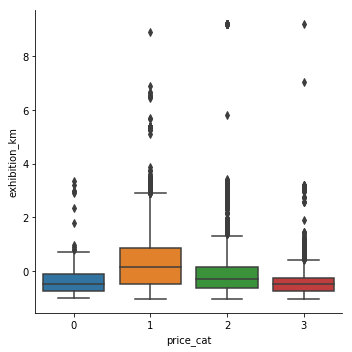

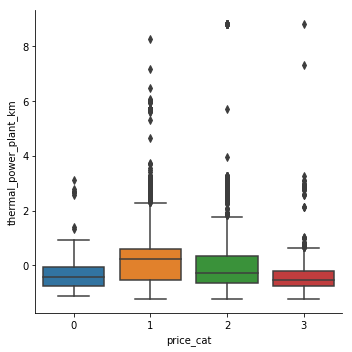

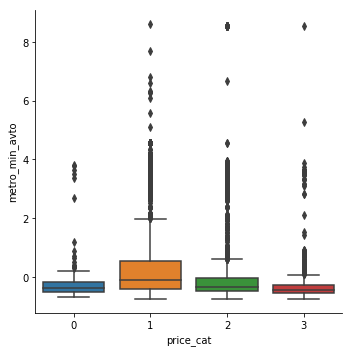

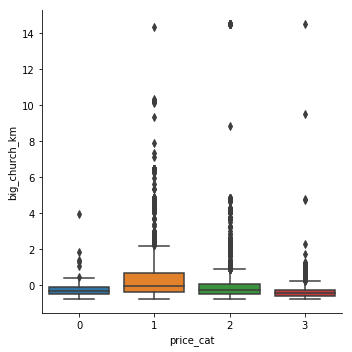

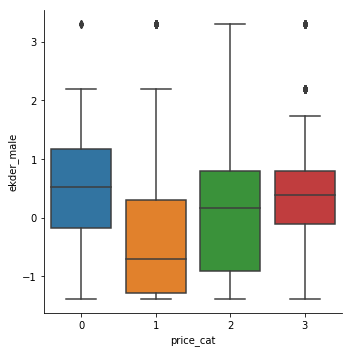

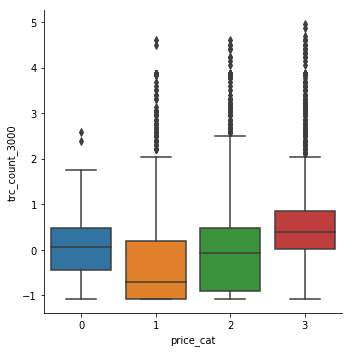

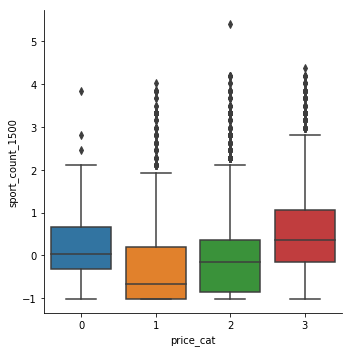

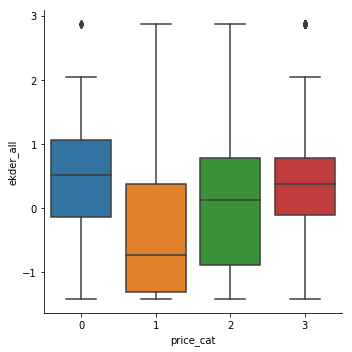

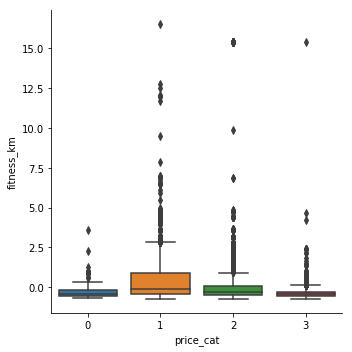

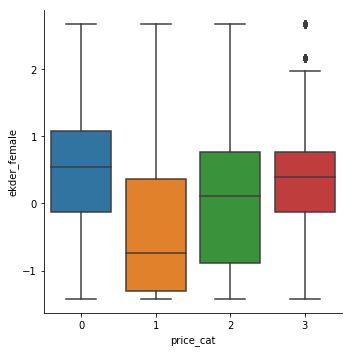

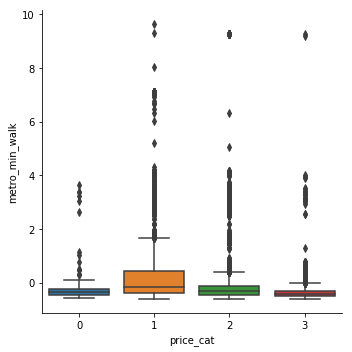

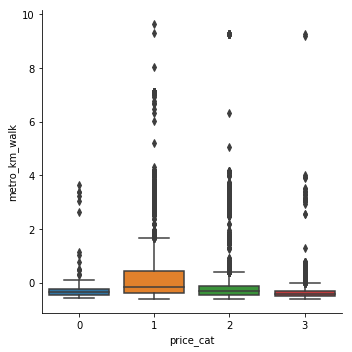

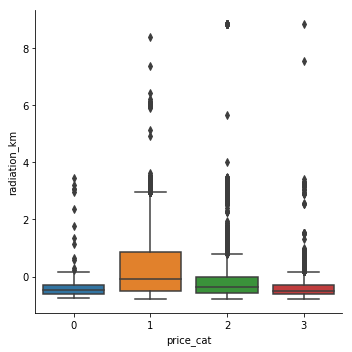

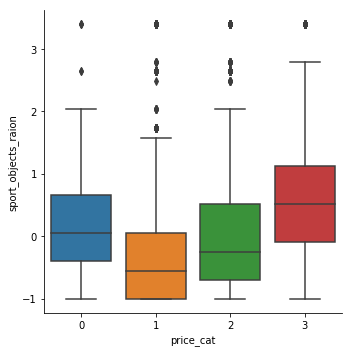

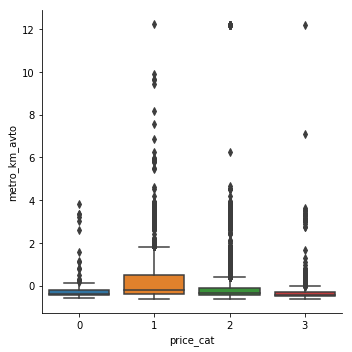

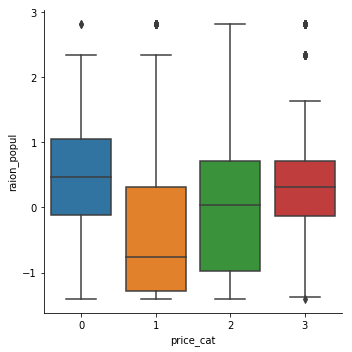

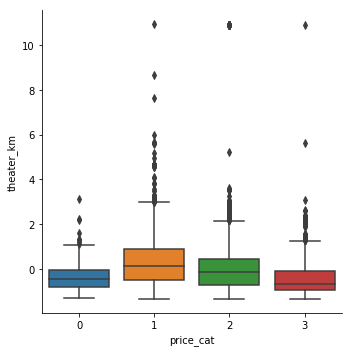

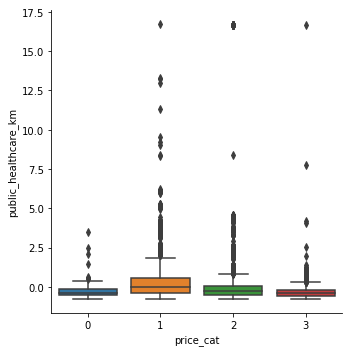

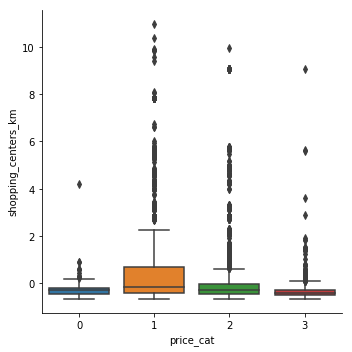

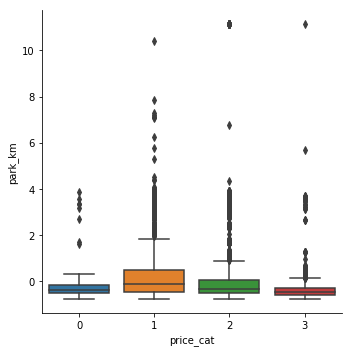

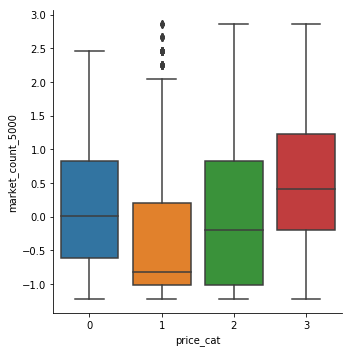

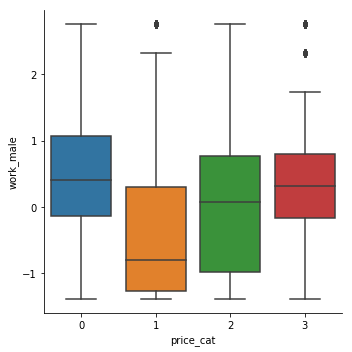

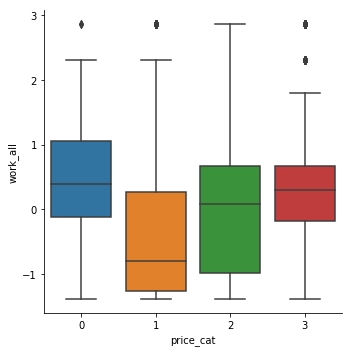

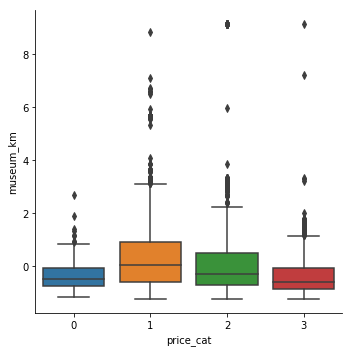

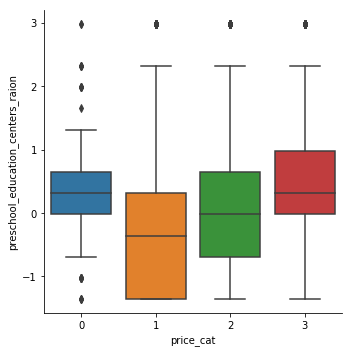

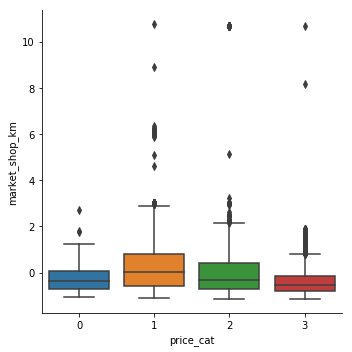

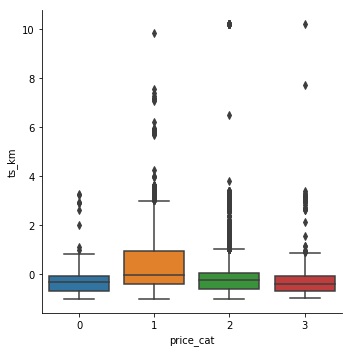

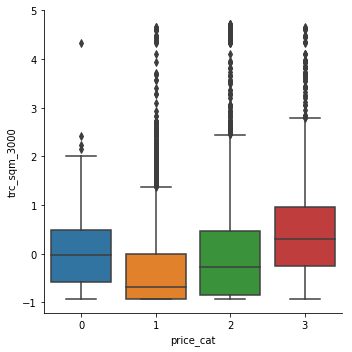

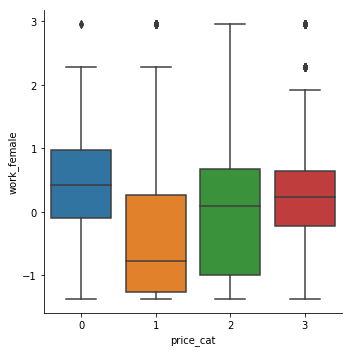

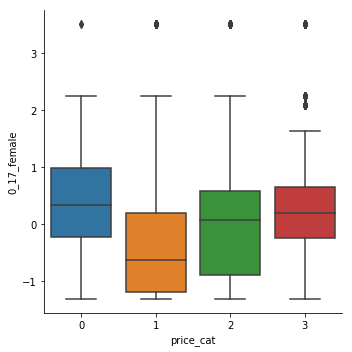

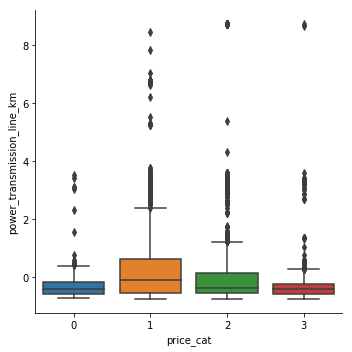

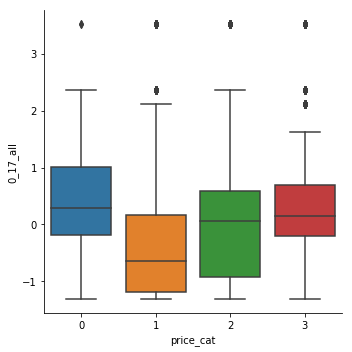

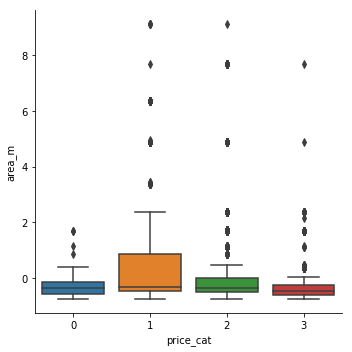

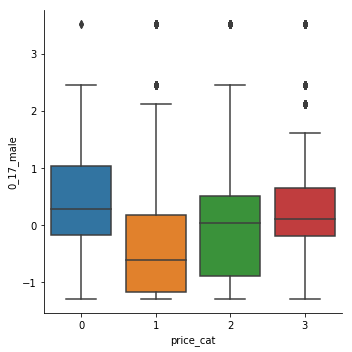

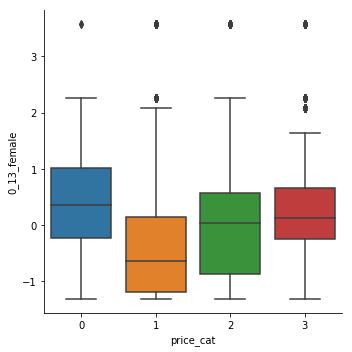

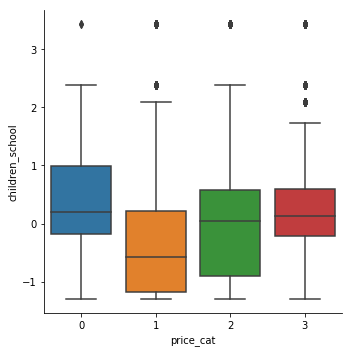

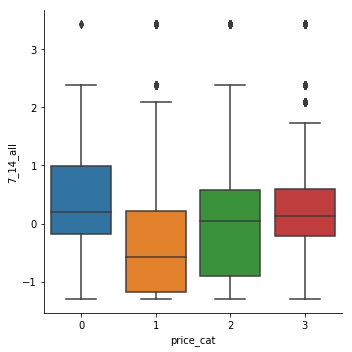

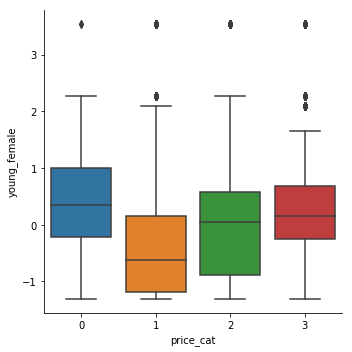

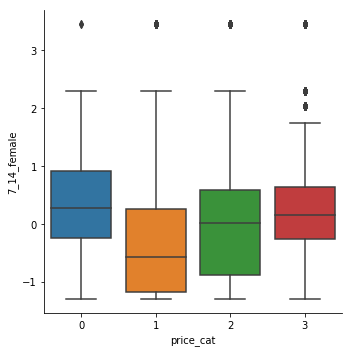

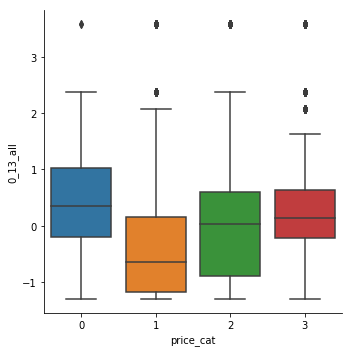

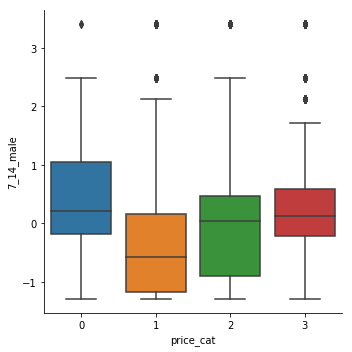

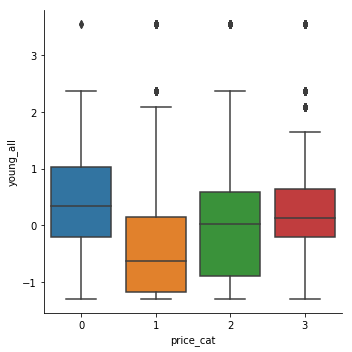

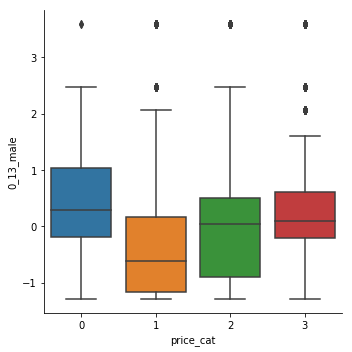

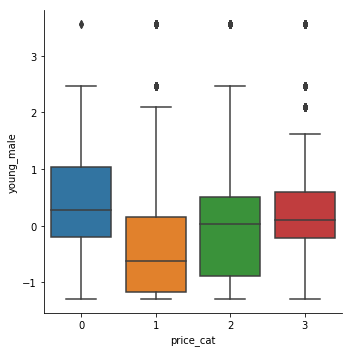

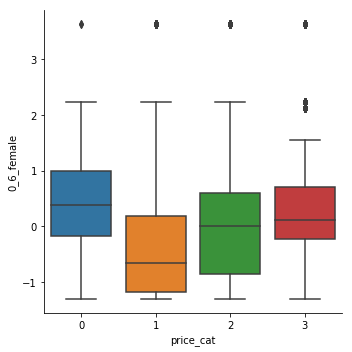

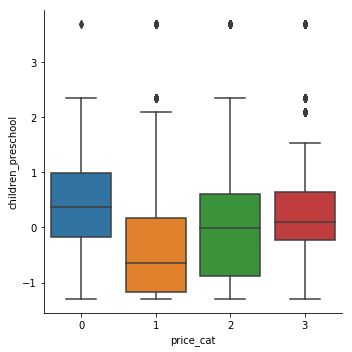

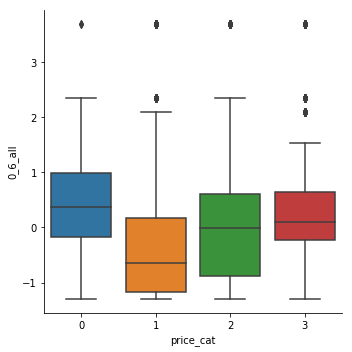

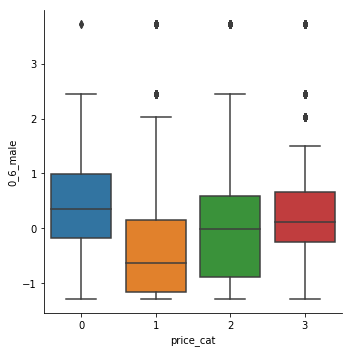

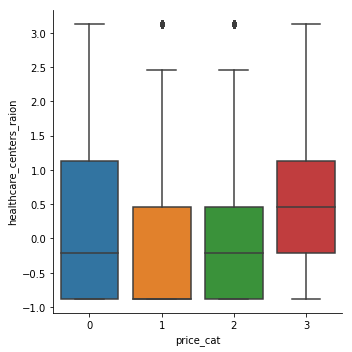

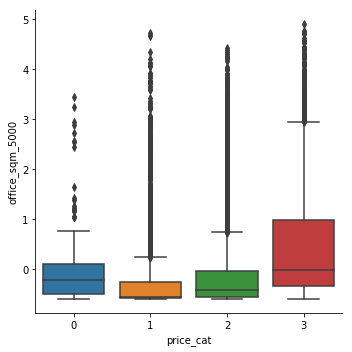

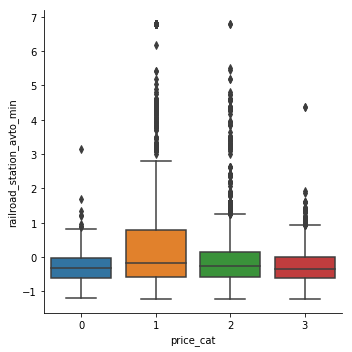

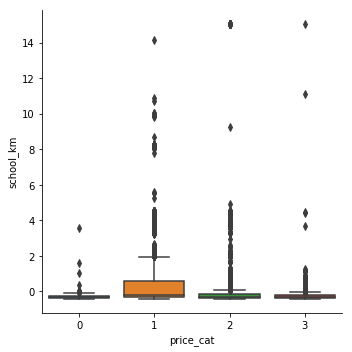

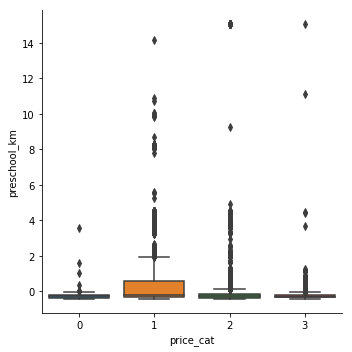

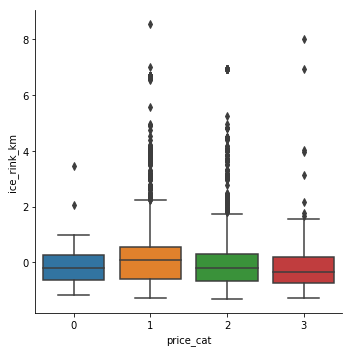

In [99]:
for col in xfinal:
    sns.catplot(x="price_cat", y=col, kind="box", data=X_train[['price_cat',col]])

2018-10-29 17:46:26.395624
2018-10-29 17:46:26.447056


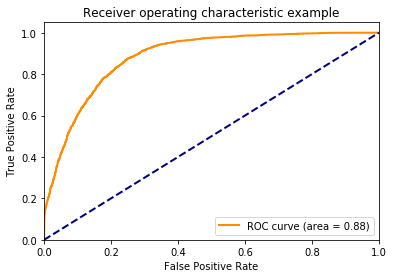

2018-10-29 17:47:23.181689


In [112]:
# Learn to predict each class against the other
print (dt.datetime.now())
n_classes = 4
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, max_depth=10,random_state=0, n_jobs=2))
print (dt.datetime.now())
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

y_true = label_binarize(y_test, classes=[0, 1, 2, 3])

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print (dt.datetime.now())

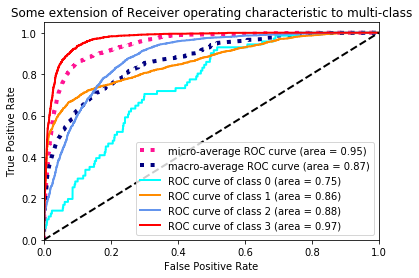

In [113]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()